<a href="https://colab.research.google.com/github/eflores5000/estrategia2/blob/main/Ejemplo_desde_cero_de_una_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U keras-tuner
from keras.datasets import mnist
from keras import layers, models
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import Callback
import kerastuner as kt
from keras import callbacks
from keras import optimizers
from keras import models
from google.colab import files
!pip install quickdraw
from quickdraw import QuickDrawData
from google.colab import output
import os
import math
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers, optimizers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


<ipython-input-1-2075bb2f3160>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
#https://quickdraw.readthedocs.io/en/latest/api.html#quickdrawdata
qd_data = QuickDrawData(jit_loading=False, cache_dir='/content/quickdrawcache', print_messages=False)
classes = qd_data.drawing_names

In [8]:
#limitaré el dataset a 10 clases.
classes = classes[:3]

In [9]:
!rm -r '/content/Dataset'
!mkdir '/content/Dataset'
!mkdir '/content/Dataset/Train'
!mkdir '/content/Dataset/Test'


imgs_w = 255
imgs_h = 255


def get_class_count(label):
  max_index = 0
  while True:
    max_index+=1
    try:
      qd_data.get_drawing(label, max_index)
    except:
      break
  return max_index

def create_dir(dirpath):
  try:
    os.mkdir(dirpath)
  except:
    pass

train_dir_base = "/content/Dataset/Train"
test_dir_base = "/content/Dataset/Test"


for each_class in classes:

  train_dir = f"{train_dir_base}/{each_class.replace(' ', '_')}"
  test_dir = f"{test_dir_base}/{each_class.replace(' ', '_')}"

  create_dir(train_dir)
  create_dir(test_dir)

  class_data_count = get_class_count(each_class)

  train_index = 0
  for i in range(math.floor(class_data_count*0.9)):
    img = qd_data.get_drawing(each_class, train_index)
    filename = f"{each_class.replace(' ', '_')}_{train_index}.jpg"
    img.image.save(f"{train_dir}/{filename}")
    train_index+=1

  test_index = 0
  for i in range(math.floor(class_data_count*0.9), class_data_count):
    img = qd_data.get_drawing(each_class, test_index)
    filename = f"{each_class.replace(' ', '_')}_{test_index}.jpg"
    img.image.save(f"{test_dir}/{filename}")
    test_index+=1

# Usamos un “data generator” para tener un dataset más grande.
# Básicamente ésto lo que hace es crear imágenes nuevas a partir del dataset original.
# Lo hace aplicando transformaciones como zoom, traslación o rotación.

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

# Dividimos el dataset en datos de entrenamiento, validación y test.
train_generator = train_datagen.flow_from_directory(
  train_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'grayscale',
  subset = 'training'
)
val_generator = test_datagen.flow_from_directory(
  test_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'grayscale',
  subset = 'validation'
)
test_generator = test_datagen.flow_from_directory(
  test_dir_base,
  target_size = (imgs_w,imgs_h),
  batch_size = 128,
  class_mode = 'categorical',
  color_mode = 'grayscale'
)

Found 2700 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [10]:
# Paso muy importante, buscamos los hyperparámetros ideales para nuestro modelo.

def model_generator(hp):
# numero filtros convoluciones
  filters = hp.Choice('filters', values=[32, 64, 128]) #numero de neuronas
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = models.Sequential() # convolution layers:

  # Bloque 1
  model.add(layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5), input_shape=(imgs_w,imgs_h,1))),
  model.add(layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))),
  model.add(layers.MaxPool2D((2,2))),

  # Bloque 2
  model.add(layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))),
  model.add(layers.Conv2D(filters*2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))),
  model.add(layers.MaxPool2D((2,2))),
  model.add(layers.Dropout(0.3)),

  # Bloque 3
  model.add(layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))),
  model.add(layers.Conv2D(filters*4, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-5))),
  model.add(layers.MaxPool2D((2,2))),
  model.add(layers.Dropout(0.4)),  # capa del input del clasificador:

  # Clasificador
  model.add(layers.Flatten()),     #numero de neuronas

  # Red oculta opcional:
  #hp_units = hp.Int(“units”, min_value = 32, max_value=512, step=32)# hidden layers:
  #model.add(layers.Dense(units = hp_units, activation=’relu’, kernel_regularizer=regularizers.l2(1e-5))),
  #model.add(layers.Dense(units = hp_units/2, activation=’relu’, kernel_regularizer=regularizers.l2(1e-5))),

  model.add(layers.Dropout(0.2)),# output layer

  # Capa de salida
  model.add(layers.Dense(len(classes),activation='softmax'))

  # Compilación
  model.compile(optimizer= optimizers.Adam(learning_rate=hp_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(
  model_generator,
  objective = 'val_accuracy',
  max_epochs = 20,
  directory = 'models',
  project_name = 'psm'
)

tuner.search(train_generator, epochs = 20, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps)

# Mejor combinación
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"🔎 Mejores hiperparámetros encontrados:")
print(f"  - Filtros: {best_hps.get('filters')}")
print(f"  - Learning rate: {best_hps.get('learning_rate')}")
#print(f"  - Neuronas en capa densa: {best_hps.get('units')}")


Trial 9 Complete [00h 00m 18s]
val_accuracy: 0.7166666388511658

Best val_accuracy So Far: 0.8999999761581421
Total elapsed time: 00h 19m 48s
🔎 Mejores hiperparámetros encontrados:
  - Filtros: 128
  - Learning rate: 0.0001


KeyError: 'units does not exist.'

In [11]:
# Por aquí personalizamos un callback que se llamará cada época para detener el
# entrenamiento si llegamos al 0.99 de accuracy en los datos de validación.

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.99:
      print('Model reached 99,9% of accuracy. Stopping training.')
      self.model.stop_training = True


In [20]:
#Configuramos el criterio para guardar los pesos del modelo para que se guarde el
#punto del entrenamiento con mejor accuracy en los datos de validación.

checkpoint_save = callbacks.ModelCheckpoint(
  filepath = 'model_checkpoints/checkpoint.h5',
  save_freq = 'epoch',
  save_weights_only = False,
  monitor = 'val_accuracy',
  save_best_only = True,
  verbose = 1
)

In [21]:
#Instanciamos el modelo con los parámetros más eficientes.
model = model_generator(best_hps)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Si ya lo tuviéramos guardado, lo gargaríamos del siguiente modo:
#model = models.load_model(“model_checkpoints/checkpoint”)


In [23]:
#Procedemos al entrenamiento:
train_epochs = 10
early_stop_patience = 3
train_history = model.fit(
  train_generator,
  epochs=train_epochs,
  batch_size=128,
  validation_data=val_generator,
  callbacks = [
  checkpoint_save,
  #TrainingCallback(),
  callbacks.EarlyStopping(monitor = 'val_loss', patience=10, mode = 'auto')
  ] )

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5041 - loss: 1.0210
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to model_checkpoints/checkpoint.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.5081 - loss: 1.0160 - val_accuracy: 0.7333 - val_loss: 0.8416
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7491 - loss: 0.7112
Epoch 2: val_accuracy did not improve from 0.73333
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.7494 - loss: 0.7108 - val_accuracy: 0.7000 - val_loss: 0.8120
Epoch 3/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7576 - loss: 0.6386
Epoch 3: val_accuracy improved from 0.73333 to 0.76667, saving model to model_checkpoints/checkpoint.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.7590 - loss: 0.6379 - val_accuracy: 0.7667 - val_loss: 0.6868
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7955 - loss: 0.5497
Epoch 4: val_accuracy improved from 0.76667 to 0.83333, saving model to model_checkpoints/checkpoint.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.7958 - loss: 0.5488 - val_accuracy: 0.8333 - val_loss: 0.4784
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8538 - loss: 0.4112
Epoch 5: val_accuracy improved from 0.83333 to 0.91667, saving model to model_checkpoints/checkpoint.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.8537 - loss: 0.4114 - val_accuracy: 0.9167 - val_loss: 0.3086
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8746 - loss: 0.3314
Epoch 6: val_accuracy improved from 0.91667 to 0.96667, saving model to model_checkpoints/checkpoint.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.8745 - loss: 0.3319 - val_accuracy: 0.9667 - val_loss: 0.2105
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8915 - loss: 0.2893
Epoch 7: val_accuracy did not improve from 0.96667
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.8913 - loss: 0.2894 - val_accuracy: 0.9667 - val_loss: 0.1630
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9074 - loss: 0.2336
Epoch 8: val_accuracy did not improve from 0.96667
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.9071 - loss: 0.2343 - val_accuracy: 0.9500 - val_loss: 0.1643
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9118 - loss: 0.2359
Epoch 9: val_accuracy did not improve from 0.96667
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.9125 - loss: 0.2348 - val_accuracy: 0.9333 - val_loss: 0.1488
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9421 - loss: 0.1634
Epoch 10: val_accuracy improved fr

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.9420 - loss: 0.1635 - val_accuracy: 0.9833 - val_loss: 0.0855


In [24]:
#Guardamos el modelo: ¡Qué no se pierda!
!zip -r /content/model_checkpoint.zip /content/model_checkpoints
files.download('/content/model_checkpoint.zip')


  adding: content/model_checkpoints/ (stored 0%)
  adding: content/model_checkpoints/checkpoint.h5 (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
#Observamos los resultados:

results = model.evaluate(train_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.9611 - loss: 0.1223


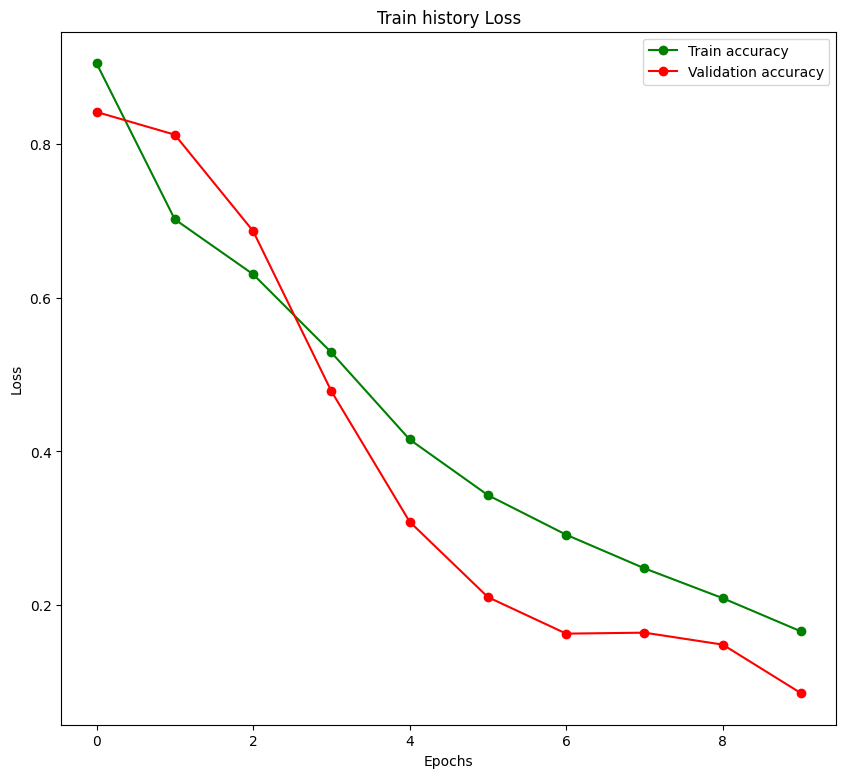

In [26]:
# Función para graficar entrenamiento:

#@title Función para graficar entrenamiento
def show_train_history(history, show_acc = False):
  epochs = [i for i in range(len(history.history['accuracy']))]
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig, ax = plt.subplots(1, 2 if show_acc else 1)
  fig.set_size_inches(16 if show_acc else 10, 9)
  if show_acc:
    ax[1].plot(epochs, train_acc, 'go-', label = 'Train accuracy')
    ax[1].plot(epochs, val_acc, 'ro-', label = 'Validation accuracy')
    ax[1].set_title('Train history Acc')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[0].plot(epochs, train_loss, 'go-', label = 'Train accuracy')
    ax[0].plot(epochs, val_loss, 'ro-', label = 'Validation accuracy')
    ax[0].set_title('Train history Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
  else:
    ax.plot(epochs, train_loss, 'go-', label = 'Train accuracy')
    ax.plot(epochs, val_loss, 'ro-', label = 'Validation accuracy')
    ax.set_title('Train history Loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
  plt.show()

show_train_history(train_history)